In [1]:
import librosa
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

Using TensorFlow backend.


In [10]:
DATA_PATH="./Word_Data/Word/"

In [3]:
DATA_PATH="./Vowel_Data/Vowel/"

In [11]:
LEN=13
num_mfcc=20
seed=0

In [12]:
def get_labels(path=DATA_PATH):
    labels=os.listdir(path)
    label_indices=np.arange(0,len(labels))
    return labels, label_indices, to_categorical(label_indices)

def speech2mfcc(file_path,max_len=LEN):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    wave=wave[::2]
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=num_mfcc)
    if (max_len > mfcc.shape[1]): #.shape[1], 1-->column
        pad_width=max_len-mfcc.shape[1]
        mfcc=np.pad(mfcc,pad_width=((0,0),(0,pad_width)),mode='constant')
    else:
        mfcc=mfcc[:,:max_len]
    return mfcc

def save_data_to_array(path=DATA_PATH, max_len=LEN):
    labels,_,_=get_labels(path)

    for label in labels:
        mfcc_vectors=[]

        speechfiles=[path + label + '/' + speech for speech in os.listdir(path+'/'+label)]
        for speech in tqdm(speechfiles,"Saving vectors to label -'{}'".format(label)):
            mfcc=speech2mfcc(speech,max_len=max_len)
            mfcc_vectors.append(mfcc)
            
        np.save(label+'.npy',mfcc_vectors)
        
def get_train_test(split_ratio=1,random_state=42):
    labels,indices,_=get_labels(DATA_PATH)

    X=np.load(labels[0]+'.npy')
    y=np.zeros(X.shape[0])

    for i,label in enumerate(labels[1:]):
        x=np.load(label+'.npy')
        X=np.vstack((X,x))
        y=np.append(y,np.full(x.shape[0],fill_value=(i+1)))
    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True)

In [13]:
save_data_to_array()

Saving vectors to label -'Word7': 100%|██████████| 40/40 [00:06<00:00,  6.03it/s]


In [14]:
np.random.seed(seed)

X_train, X_test, y_train, y_test=get_train_test()
X_train=X_train.reshape(X_train.shape[0],num_mfcc,LEN,1)
y_train_hot=to_categorical(y_train)


model=Sequential()
model.add(Conv2D(64,kernel_size=(2,2),activation='tanh',input_shape=(num_mfcc,LEN,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7,activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
history=model.fit(X_train,y_train_hot,batch_size=128,epochs=20,verbose=1)

Epoch 1/20
280/280 [==============================] - 1s 3ms/step - loss: 3.6561 - acc: 0.1929
Epoch 2/20
280/280 [==============================] - 0s 633us/step - loss: 2.8161 - acc: 0.2500
Epoch 3/20
280/280 [==============================] - 0s 623us/step - loss: 1.3772 - acc: 0.4786
Epoch 4/20
280/280 [==============================] - 0s 651us/step - loss: 1.3913 - acc: 0.4929
Epoch 5/20
280/280 [==============================] - 0s 877us/step - loss: 1.1939 - acc: 0.5536
Epoch 6/20
280/280 [==============================] - 0s 874us/step - loss: 0.8026 - acc: 0.7357
Epoch 7/20
280/280 [==============================] - 0s 646us/step - loss: 0.8217 - acc: 0.7179
Epoch 8/20
280/280 [==============================] - 0s 640us/step - loss: 0.7507 - acc: 0.6821
Epoch 9/20
280/280 [==============================] - 0s 672us/step - loss: 0.5889 - acc: 0.7929
Epoch 10/20
280/280 [==============================] - 0s 636us/step - loss: 0.5809 - acc: 0.8000
Epoch 11/20
280/280 [==========

In [15]:
history_dict=history.history

In [16]:
#word

loss_word=history_dict['loss']
acc_word=history_dict['acc']

In [9]:
#Vowel

loss_vowel=history_dict['loss']
acc_vowel=history_dict['acc']

In [17]:
epochs=range(1,len(loss_word)+1)

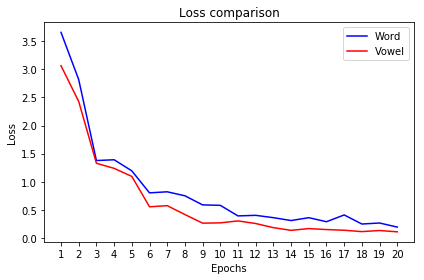

In [18]:
#plt.figure(figsize=(10,4))
plt.plot(epochs,loss_word,'b',label='Word')
plt.plot(epochs,loss_vowel,'r',label='Vowel')
plt.title('Loss comparison')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('./Result/Meet_the_Reviewer_Comments/Final_loss_compare_LEN_'+str(LEN)+'.svg',format='svg',dpi=600)

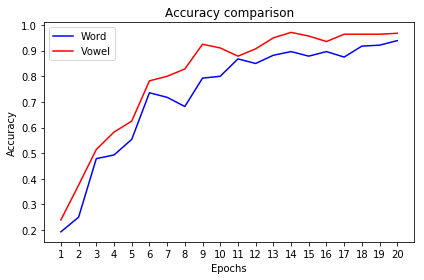

In [19]:
#plt.figure(figsize=(10,4))
plt.plot(epochs,acc_word,'b',label='Word')
plt.plot(epochs,acc_vowel,'r',label='Vowel')
plt.title('Accuracy comparison')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('./Result/Meet_the_Reviewer_Comments/Final_accuracy_compare_LEN_'+str(LEN)+'.svg',format='svg',dpi=600)